In [8]:
#standard packages
import pandas as pd
import numpy as np

#webscraping packages & SQLite
import pymongo
from pymongo import MongoClient
from bs4 import BeautifulSoup, SoupStrainer
import requests
import urllib.request
import functions as mf

#nlp packages
import string
import nltk
from nltk.corpus import stopwords
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_lg')

#EDA packages
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors 
from gensim.scripts.glove2word2vec import glove2word2vec

In [2]:
client = MongoClient()
db = client.case_files
cases = db.cases

In [3]:
df = pd.DataFrame(list(cases.find()))

In [4]:
def combine_other_opinions(case_text_entry):
    return [case_text_entry[i]['text'].lower().translate(str.maketrans('', '', string.punctuation)).replace('\n', ' ').replace('•', '') for i in range(1, len(case_text_entry))]

def stop_word_remove(tokenized_text):
    token_list = []
    for token in tokenized_text:
        token_list.append(token.text)
    filtered_sentence =[] 
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return filtered_sentence

def remove_names(tokenized_text):
    pass
    

In [5]:
def clean_data(df):
    df['attorneys'] = df['attorneys'].apply(lambda x: None if len(x) == 0  else x[0].split(','))
    df['judges'] = df['judges'].apply(lambda x: None if len(x) == 0 else x[0])
    df['majority_opinion'] = df['case_text'].apply(lambda x: None if len(x) == 0 else (x[0]['text'].lower().translate(str.maketrans('', '', string.punctuation)).replace('\n', ' ').replace('•', '')))
    df['other_opinions'] = df['case_text'].apply(lambda x: None if len(x) == 0 else combine_other_opinions(x))
    df['other_opinions'] = df['other_opinions'].apply(lambda x: None if len(x) == 0 else (x[0].lower()))
    df['tokenized_majority_opinion'] = df['majority_opinion'].apply(lambda x: nlp.tokenizer(x))
    df['tokenized_other_opinions'] = df['other_opinions'].apply(lambda x: nlp.tokenizer(x) if x != None else False)
    df['no_stop_words_majority'] = df['tokenized_majority_opinion'].apply(lambda x: stop_word_remove(x))
    df['no_stop_words_other'] = df['tokenized_other_opinions'].apply(lambda x: stop_word_remove(x) if x != False else False)                                                      
    return df

In [6]:
test = clean_data(df)
test.head(15)

,_id,attorneys,case_id,case_name,case_text,court_id,court_name,decision_date,frontend_url,judges,majority_opinion,other_opinions,tokenized_majority_opinion,tokenized_other_opinions,no_stop_words_majority,no_stop_words_other
0,5d66e470e59ddf33befdfe06,None,37588,In the matter of the Complaint made against Jo...,"[{'text': 'ORDER OF PUBLIC CENSURE Whereas, In...",8874,Kansas Supreme Court,1970,https://cite.case.law/kan/206/335/,None,order of public censure whereas in a proceedin...,None,"(order, of, public, censure, whereas, in, a, p...",False,"[order, public, censure, proceeding, conducted...",False
1,5d66e470e59ddf33befdfe07,None,37656,In the matter of the Complaint made against Ro...,"[{'text': 'ORDER OF PUBLIC CENSURE Whereas, In...",8874,Kansas Supreme Court,1970,https://cite.case.law/kan/206/334/,None,order of public censure whereas in a proceedin...,None,"(order, of, public, censure, whereas, in, a, p...",False,"[order, public, censure, proceeding, conducted...",False
2,5d66e470e59ddf33befdfe08,None,1747634,State of Connecticut v. Anonymous (1971-5),"[{'text': 'Moraghan, J. The defendant has move...",13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/443/,None,moraghan j the defendant has moved to suppress...,None,"(moraghan, j, the, defendant, has, moved, to, ...",False,"[moraghan, j, defendant, moved, suppress, cert...",False
3,5d66e470e59ddf33befdfe09,None,1747661,State of Connecticut v. Anonymous (1971-3),"[{'text': 'Dearington, J. Following a trial to...",13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/393/,None,dearington j following a trial to the jury the...,None,"(dearington, j, following, a, trial, to, the, ...",False,"[dearington, j, following, trial, jury, defend...",False
4,5d66e470e59ddf33befdfe0a,None,1747680,State of Connecticut v. Anonymous (1971-7),"[{'text': 'Casale, J. The defendant, after a t...",13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/462/,None,casale j the defendant after a trial to the co...,None,"(casale, j, the, defendant, after, a, trial, t...",False,"[casale, j, defendant, trial, court, found, gu...",False
5,5d66e470e59ddf33befdfe0b,None,1747684,State of Connecticut v. Anonymous (1971-2) (si...,"[{'text': 'Jacobs, J. Following a jury trial, ...",13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/372/,None,jacobs j following a jury trial the defendants...,casale j concurring i concur in the result but...,"(jacobs, j, following, a, jury, trial, the, de...","(casale, j, concurring, i, concur, in, the, re...","[jacobs, j, following, jury, trial, defendants...","[casale, j, concurring, concur, result, ground..."
6,5d66e470e59ddf33befdfe0c,None,1747761,State of Connecticut v. Anonymous (1971-6),[{'text': 'Per Curiam. The defendant was given...,13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/451/,None,per curiam the defendant was given a uniform t...,None,"(per, curiam, the, defendant, was, given, a, u...",False,"[curiam, defendant, given, uniform, traffic, s...",False
7,5d66e470e59ddf33befdfe0d,None,1747765,State of Connecticut v. Anonymous (1971-4),"[{'text': 'Bieluch, J. The defendant was one o...",13405,Connecticut Circuit Court,1970,https://cite.case.law/conn-cir-ct/6/402/,None,bieluch j the defendant was one of a group of ...,None,"(bieluch, j, the, defendant, was, one, of, a, ...",False,"[bieluch, j, defendant, group, thirty, demonst...",False
8,5d66e470e59ddf33befdfe0e,None,1768441,State of Connecticut v. Anonymous (1971-9),"[{'text': 'Armentano, J. The defendant is char...",8872,Connecticut Superior Court,1970,https://cite.case.law/conn-supp/29/153/,None,armentano j the defendant is charged with poss...,None,"(armentano, j, the, defendant, is, charged, wi...",False,"[armentano, j, defendant, charged, possession,...",False
9,5d66e470e59ddf33befdfe0f,None,1768489,State of Connecticut v. Anonymous (1971-1),"[{'text': 'Palmer, J. This is an information i...",8872,Connecti

In [7]:
majority_no_stop = test['no_stop_words_majority'].sum()

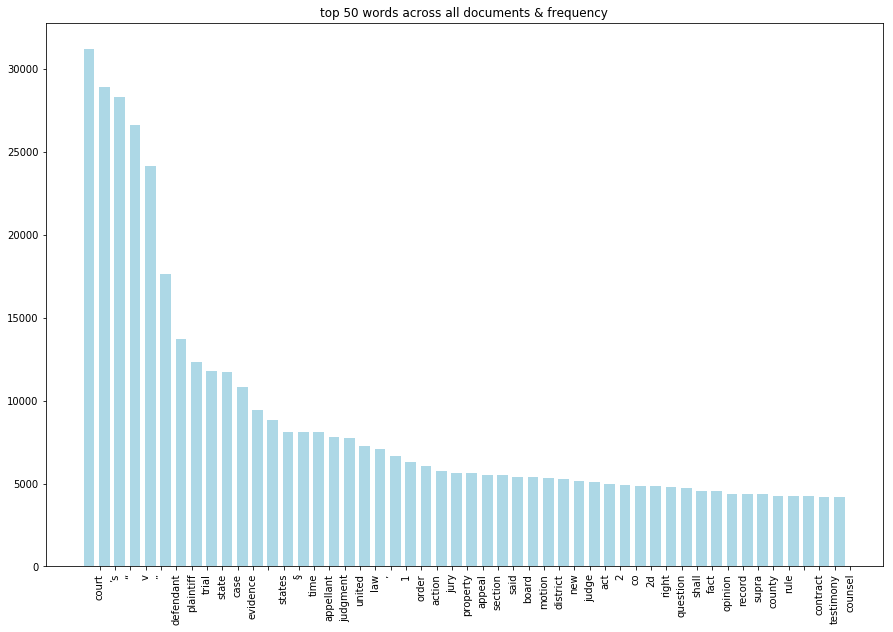

In [13]:
counter = Counter(majority_no_stop)
counter_top = OrderedDict(counter.most_common(50))
words = counter_top.keys()
word_counts = counter_top.values()

# Plot histogram using matplotlib bar().

plt.figure(figsize=(15,10))
indexes = np.arange(len(words))
width = .7

plt.bar(indexes, word_counts, width, color = 'lightblue')
plt.xticks(indexes + width, words, rotation='vertical')
plt.title('top 50 words across all documents & frequency')
plt.show()
